In [1]:
from modules.data import data_reader
import pandas as pd
import numpy as np
import os

In [18]:
evaluation = data_reader.read_data(match=["stock"], location="evaluation")
prediction = data_reader.read_data(match=["stock"], location="prediction")

# Data aggregation

In [3]:
# path to evaluation directory
project_folder = os.getcwd()
directory = os.path.abspath(os.path.join(project_folder, "results", "evaluation"))

In [4]:
# Initialize an empty DataFrame to store the aggregated results
aggregated_evaluation = pd.DataFrame()

In [5]:
# List all files in the directory
files = [f for f in os.listdir(directory) if f.endswith('.csv')]

In [6]:
# Process each file
for file in files:
    # Extract parameters from the file name
    base_name = os.path.splitext(file)[0]
    parameters = base_name.split('__')
    param_dict = {}
    for param in parameters:
        key, value = param.split('=')
        param_dict[key] = value

    # Read the CSV file into a DataFrame
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)

    # Add parameter columns to the DataFrame
    for key, value in param_dict.items():
        df[key] = value

    # Append the DataFrame to the aggregated DataFrame
    aggregated_evaluation = pd.concat([aggregated_evaluation, df], ignore_index=True)

In [7]:
param_columns = list(param_dict.keys())
csv_columns = list(df.columns)
all_columns = param_columns + [col for col in csv_columns if col not in param_columns]
aggregated_evaluation = aggregated_evaluation[all_columns]

In [8]:
aggregated_evaluation.rename(columns={"Unnamed: 0" : "model"}, inplace=True)

In [41]:
pd.set_option('display.max_rows', None)

In [42]:
aggregated_evaluation

,P_L,T,FR,T_O_D,FO,C_L_T_S,FT_S_D,S_D,E_D,FT_L,D_L,model,r2,mse,mae,rmse,mda,mape
0,1,AAPL,daily,return,10,128,2022-07-07,2023-07-07,2024-07-07,250,250,arima,-0.274429,0.000233,0.012304,0.015262,0.333333,9.149839e-01
1,1,AAPL,daily,return,10,128,2022-07-07,2023-07-07,2024-07-07,250,250,lag_llama,-0.278130,0.000234,0.012767,0.015284,0.555556,1.041908e+00
2,1,AAPL,daily,return,10,128,2022-07-07,2023-07-07,2024-07-07,250,250,autoregressor,-1.077641,0.000380,0.016222,0.019486,0.555556,1.660689e+00
3,1,AAPL,daily,return,10,128,2022-07-07,2023-07-07,2024-07-07,250,250,ft_lag_llama,-0.076005,0.000197,0.011359,0.014023,0.555556,8.360151e-01
4,1,AAPL,daily,return,10,32,2022-07-07,2023-07-07,2024-07-07,250,250,arima,-0.329972,0.000243,0.013105,0.015591,0.000000,1.000000e+00
5,1,AAPL,daily,return,10,32,2022-07-07,2023-07-07,2024-07-07,250,250,lag_llama,-0.451896,0.000265,0.011956,0.016290,0.444444,1.028259e+00
6,1,AAPL,daily,return,10,32,2022-07-07,2023-07-07,2024-07-07,250,250,autoregressor,-1.077641,0.000380,0.016222,0.019486,0.555556,1.660689e+00
7,1,AAPL,daily,return,10,32,2022-07-07,2023-07-07,2024-07-07,250,250,ft_lag_llama,-0.585187,0.000290,0.015151,0.017021,0.333333,1.384978e+00
8,1,AAPL,daily,return,10,64,2022-07-07,2023-07-07,2024-07-07,250,250,arima,-0.329972,0.000243,0.013105,0.015591,0.000000,1.000000e+00
9,1,AAPL,daily,return,10,64,2022-07-07,2023-07-07,2024-07-07,250,250,lag_llama,-0.155102,0.000211,0.010755,0.014530,0.333333,8.030108e-01


# Average metrics across all experiments

In [43]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model"]
group = ["model"]
aggregated_evaluation[metrics].groupby(group).median()

,r2,mse,mae,rmse,mda,mape
model,,,,,,
arima,-0.082966,0.045825,0.123445,0.158963,0.388889,0.457161
autoregressor,-0.661425,0.044448,0.127111,0.158501,0.500000,0.836816
ft_lag_llama,-0.982496,0.093447,0.208398,0.224500,0.555556,0.478313
lag_llama,-0.460128,0.390092,0.367261,0.449710,0.444444,0.485550


# Metrics across type of data and model

In [44]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "T_O_D"]
group = ["T_O_D", "model"]
aggregated_evaluation[metrics].groupby(group).median()

r2        mse       mae      rmse       mda  \
T_O_D  model                                                               
return arima          -0.218474   0.000008  0.001744  0.002843  0.222222   
       autoregressor  -1.081167   0.000017  0.003108  0.004066  0.444444   
       ft_lag_llama   -0.403093   0.000013  0.002351  0.003611  0.444444   
       lag_llama      -0.276851   0.000010  0.002235  0.003139  0.444444   
stock  arima           0.501951   0.310444  0.356044  0.557175  0.555556   
       autoregressor   0.515112   0.302241  0.337000  0.549764  0.555556   
       ft_lag_llama  -18.396775  56.724834  7.122389  7.531589  0.555556   
       lag_llama     -23.015552   6.511864  2.093663  2.551835  0.555556   

                              mape  
T_O_D  model                        
return arima          1.000000e+00  
       autoregressor  1.407969e+11  
       ft_lag_llama   1.168955e+10  
       lag_llama      2.637251e+11  
stock  arima          1.849061e-03  
       autoregressor  1.750141e-03  
       ft_lag_llama   3.261042e-02  
       lag_llama      1.086448e-02

# Metrics across Context length and model

In [45]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "C_L_T_S"]
group = ["C_L_T_S", "model"]
aggregated_evaluation[metrics].groupby(group).median()

r2       mse       mae      rmse       mda  \
C_L_T_S model                                                             
128     arima         -0.054393  0.045820  0.123044  0.158799  0.388889   
        autoregressor -0.661425  0.044448  0.127111  0.158501  0.500000   
        ft_lag_llama  -8.838353  0.932865  0.609656  0.689934  0.555556   
        lag_llama     -4.862593  1.617140  0.888211  0.906815  0.555556   
32      arima         -0.133112  0.077896  0.155848  0.204993  0.333333   
        autoregressor -0.661425  0.044448  0.127111  0.158501  0.500000   
        ft_lag_llama  -0.982496  2.433858  0.861798  1.111623  0.500000   
        lag_llama     -0.460128  0.390092  0.366855  0.449710  0.444444   
64      arima         -0.199989  0.048552  0.131033  0.163407  0.388889   
        autoregressor -0.661425  0.044448  0.127111  0.158501  0.500000   
        ft_lag_llama  -1.157493  0.093424  0.207389  0.223785  0.500000   
        lag_llama     -6.062854  1.011417  0.631662  0.718359  0.388889   

                           mape  
C_L_T_S model                    
128     arima          0.454926  
        autoregressor  0.836816  
        ft_lag_llama   0.475969  
        lag_llama      0.596069  
32      arima          0.455415  
        autoregressor  0.836816  
        ft_lag_llama   0.708794  
        lag_llama      0.578577  
64      arima          0.492050  
        autoregressor  0.836816  
        ft_lag_llama   0.580876  
        lag_llama      0.485550

# Metrics across data frequency and model

In [46]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "FR"]
group = ["FR", "model"]
aggregated_evaluation[metrics].groupby(group).median()

r2         mse        mae       rmse       mda  \
FR       model                                                                  
daily    arima           0.161701    3.934145   1.065838   1.410297  0.388889   
         autoregressor  -0.191448    5.547120   1.408111   1.675115  0.611111   
         ft_lag_llama   -0.913570   40.739721   3.568770   4.521801  0.555556   
         lag_llama     -11.733724  436.397818  13.918472  14.779700  0.500000   
hourly   arima           0.213958    0.153218   0.174277   0.278239  0.333333   
         autoregressor  -0.313593    0.151129   0.170054   0.276915  0.500000   
         ft_lag_llama   -3.765953    2.433720   0.855417   1.104935  0.500000   
         lag_llama      -0.408009    0.457635   0.401502   0.479958  0.444444   
minutely arima          -0.290484    0.045705   0.117500   0.151901  0.388889   
         autoregressor  -0.663188    0.044259   0.119684   0.149687  0.444444   
         ft_lag_llama   -1.015843    0.093304   0.201494   0.216753  0.500000   
         lag_llama      -5.201595    0.389961   0.361507   0.442336  0.500000   

                                mape  
FR       model                        
daily    arima          4.646532e-01  
         autoregressor  8.368157e-01  
         ft_lag_llama   4.783126e-01  
         lag_llama      4.855499e-01  
hourly   arima          4.510607e-01  
         autoregressor  7.039844e+10  
         ft_lag_llama   9.618391e-01  
         lag_llama      1.075962e+11  
minutely arima          5.140689e-01  
         autoregressor  4.776185e+11  
         ft_lag_llama   1.708215e+11  
         lag_llama      1.899487e+11

# Metrics across type of data, frequency and model

In [38]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "T_O_D", "FR"]
group = ["T_O_D", "FR", "model"]
aggregated_evaluation[metrics].groupby(group).mean()

r2          mse        mae       rmse  \
T_O_D  FR       model                                                         
return daily    arima          -0.311458     0.000240   0.012838   0.015481   
                autoregressor  -1.077641     0.000380   0.016222   0.019486   
                ft_lag_llama   -0.330443     0.000243   0.013214   0.015545   
                lag_llama      -0.295043     0.000237   0.011826   0.015368   
       hourly   arima          -0.066799     0.000008   0.001773   0.002869   
                autoregressor  -1.142299     0.000017   0.003108   0.004066   
                ft_lag_llama   -0.605339     0.000012   0.002356   0.003516   
                lag_llama      -0.292922     0.000010   0.002264   0.003158   
       minutely arima          -0.191531     0.000002   0.001154   0.001405   
                autoregressor  -1.081167     0.000003   0.001368   0.001858   
                ft_lag_llama   -0.249063     0.000002   0.001260   0.001438   
                lag_llama      -0.252000     0.000002   0.001220   0.001440   
stock  daily    arima           0.710744    10.512411   2.515486   3.212314   
                autoregressor   0.694745    11.093860   2.800000   3.330745   
                ft_lag_llama  -12.304114   483.510398  19.387862  20.449220   
                lag_llama     -29.772152  1118.349993  32.137613  33.279059   
       hourly   arima           0.495338     0.314566   0.370423   0.560807   
                autoregressor   0.515112     0.302241   0.337000   0.549764   
                ft_lag_llama  -80.310566    50.682544   6.062712   6.416206   
                lag_llama      -7.262289     5.150054   1.684885   2.113675   
       minutely arima          -0.612229     0.114605   0.260445   0.335985   
                autoregressor  -0.245209     0.088515   0.238000   0.297516   
                ft_lag_llama  -50.866786     3.686944   1.528179   1.599757   
                lag_llama     -27.306946     2.012196   1.245992   1.367888   

                                    mda          mape  
T_O_D  FR       model                                  
return daily    arima          0.111111  9.716613e-01  
                autoregressor  0.555556  1.660689e+00  
                ft_lag_llama   0.407407  1.087378e+00  
                lag_llama      0.444444  9.577261e-01  
       hourly   arima          0.074074  9.232592e-01  
                autoregressor  0.444444  1.407969e+11  
                ft_lag_llama   0.370370  1.405755e+11  
                lag_llama      0.444444  2.805891e+11  
       minutely arima          0.333333  3.135289e+11  
                autoregressor  0.444444  9.552370e+11  
                ft_lag_llama   0.555556  4.284309e+11  
                lag_llama      0.296296  4.286795e+11  
stock  daily    arima          0.592593  1.166851e-02  
                autoregressor  0.666667  1.294222e-02  
                ft_lag_llama   0.592593  8.971462e-02  
                lag_llama      0.518519  1.490713e-01  
       hourly   arima          0.518519  1.923678e-03  
                autoregressor  0.555556  1.750141e-03  
                ft_lag_llama   0.555556  3.146299e-02  
                lag_llama      0.481481  8.746948e-03  
       minutely arima          0.444444  1.129576e-03  
                autoregressor  0.444444  1.032405e-03  
                ft_lag_llama   0.444444  6.632714e-03  
                lag_llama      0.555556  5.408754e-03

# Metrics across Context length, frequency and model

In [39]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "C_L_T_S", "FR"]
group = ["C_L_T_S", "FR", "model"]
aggregated_evaluation[metrics].groupby(group).mean()

r2         mse        mae       rmse  \
C_L_T_S FR       model                                                        
128     daily    arima           0.254538    3.934140   1.065438   1.410133   
                 autoregressor  -0.191448    5.547120   1.408111   1.675115   
                 ft_lag_llama   -8.674809  332.058356  12.519622  12.892241   
                 lag_llama     -14.382535  535.820918  16.182207  16.375611   
        hourly   arima           0.230322    0.153218   0.174234   0.278201   
                 autoregressor  -0.313593    0.151129   0.170054   0.276915   
                 ft_lag_llama  -45.203686   28.362423   3.600933   3.767440   
                 lag_llama      -4.861953    3.255937   1.081274   1.277487   
        minutely arima          -0.173461    0.045704   0.117464   0.151832   
                 autoregressor  -0.663188    0.044259   0.119684   0.149687   
                 ft_lag_llama  -12.704744    0.932767   0.604583   0.683618   
                 lag_llama     -22.321776    1.617024   0.882423   0.899863   
32      daily    arima           0.210462    4.526704   1.174053   1.512219   
                 autoregressor  -0.191448    5.547120   1.408111   1.675115   
                 ft_lag_llama   -0.913570   40.739721   3.568770   4.521801   
                 lag_llama     -11.733724  436.397818  13.918067  14.779700   
        hourly   arima           0.227100    0.155226   0.178894   0.280009   
                 autoregressor  -0.313593    0.151129   0.170054   0.276915   
                 ft_lag_llama   -3.765953    2.433720   0.855387   1.104935   
                 lag_llama      -0.408009    0.457635   0.401502   0.479958   
        minutely arima          -0.703338    0.077775   0.149846   0.197909   
                 autoregressor  -0.663188    0.044259   0.119684   0.149687   
                 ft_lag_llama  -63.069053    4.504348   1.488141   1.501488   
                 lag_llama      -5.201595    0.389961   0.361507   0.442336   
64      daily    arima           0.133929    7.308133   1.552996   1.919341   
                 autoregressor  -0.191448    5.547120   1.408111   1.675115   
                 ft_lag_llama   -9.363457  352.467884  13.013223  13.283107   
                 lag_llama     -18.984534  705.306608  18.123885  18.786329   
        hourly   arima           0.185385    0.163418   0.205164   0.287304   
                 autoregressor  -0.313593    0.151129   0.170054   0.276915   
                 ft_lag_llama  -72.404219   45.227692   4.641280   4.757207   
                 lag_llama      -6.062854    4.011525   1.047949   1.417804   
        minutely arima          -0.328840    0.048431   0.125089   0.156345   
                 autoregressor  -0.663188    0.044259   0.119684   0.149687   
                 ft_lag_llama   -0.899976    0.093303   0.201435   0.216687   
                 lag_llama     -13.815049    1.011312   0.626889   0.711793   

                                     mda          mape  
C_L_T_S FR       model                                  
128     daily    arima          0.500000  4.624182e-01  
                 autoregressor  0.611111  8.368157e-01  
                 ft_lag_llama   0.555556  4.759692e-01  
                 lag_llama      0.611111  5.960691e-01  
        hourly   arima          0.277778  4.509003e-01  
                 autoregressor  0.500000  7.039844e+10  
                 ft_lag_llama   0.444444  2.050185e+11  
                 lag_llama      0.500000  1.318625e+11  
        minutely arima          0.388889  2.145318e+11  
                 autoregressor  0.444444  4.776185e+11  
                 ft_lag_llama   0.555556  2.407267e+11  
                 lag_llama      0.333333  1.899487e+11  
32      daily    arima          0.333333  5.054152e-01  
                 autoregressor  0.611111  8.368157e-01  
                 ft_lag_llama   0.444444  7.087944e-01  
                 lag_llama      0.388889  5.785769e-01  
        ho

In [66]:
prediction = data_reader.read_data(match=["FO=20"], location="prediction")

In [67]:
len(prediction)

2

# Prediction visualization

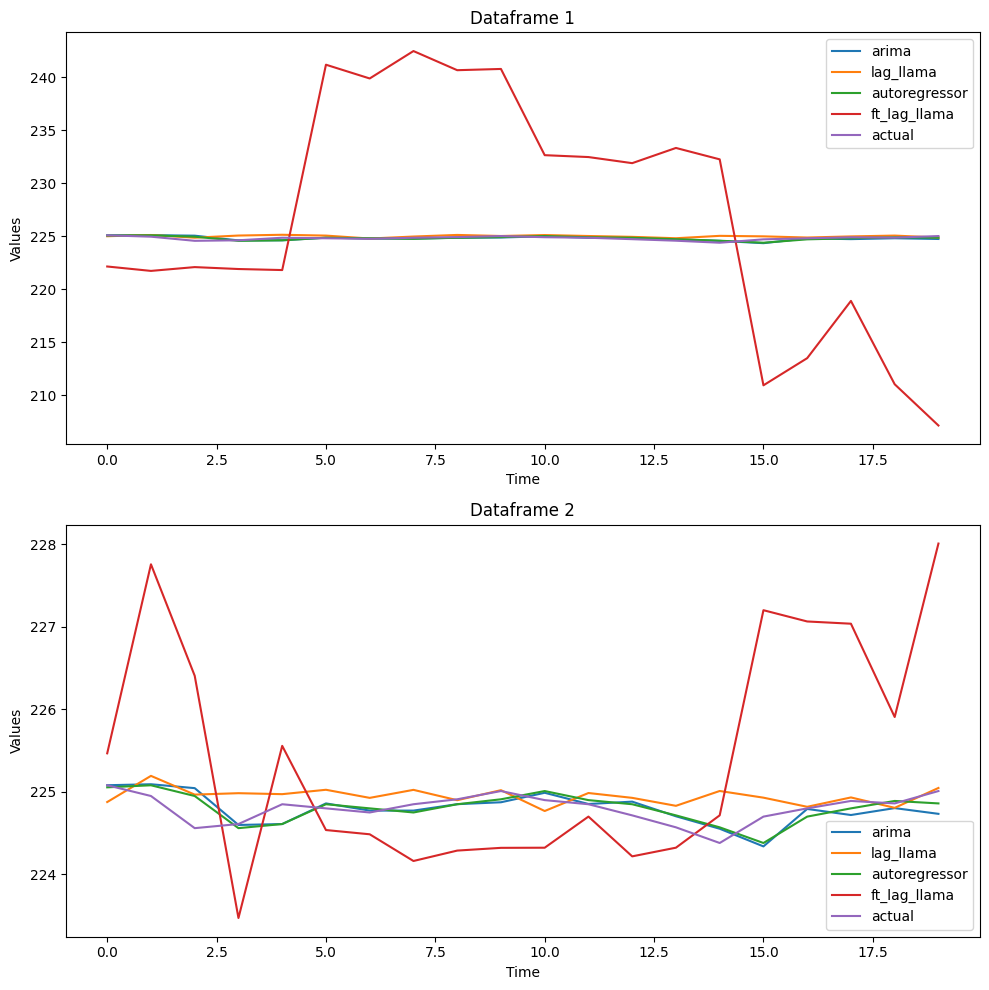

In [68]:
import matplotlib.pyplot as plt

# Assuming `prediction` is your list of dataframes
def plot_dataframes(prediction):
    num_plots = len(prediction)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))

    # Check if there's only one dataframe to handle the axes object properly
    if num_plots == 1:
        axes = [axes]

    for i, df in enumerate(prediction):
        ax = axes[i]
        df.plot(ax=ax)
        ax.set_title(f'Dataframe {i+1}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Values')

    plt.tight_layout()
    plt.show()

# Example usage with your `prediction` list
plot_dataframes(prediction)